# Generating short texts with RNN


You can generate texts using RNN, which predicts the next character of the sequence from the previous ones.

You will train a network using a small dataset of names [character-based generative model - Char-RNN] (http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

![charseq](./charseq.jpeg)
Picture taken from [Karpathy article] (http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import collections

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

The file `names` contains ~ 8k names.

The model will receive the name `Amandy` as input and will return it, only with a shift: `mandy`.

To make the network learn to generate capital letters, add a special token, a space, to the beginning:
``,
_Amandy -> Amandy_
``,

For practical use, at each step, we will input the letter predicted in the previous one.
So we need a rule to stop the generation (it could just be a limit on the number of steps).
Alternatively, you can add a special `<EOS>` token to the end of each training sample. In this case, let's denote it with `#`:

``,
_Amandy -> Amandy #
``,

We will stop generating at early `<EOS>` dropout.

In [2]:
import os
start_token = " "
eos = '#'

with open("names") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]

names = list(set(names))  # this dataset has duplicate entries
print('There are {} names: '.format(len(names)))
for x in names[::1000]:
    print(x)

There are 7578 names: 
 Cathryn#
 Inci#
 Auroora#
 Roxanna#
 Osmond#
 Ellynn#
 Kari#
 Letisha#


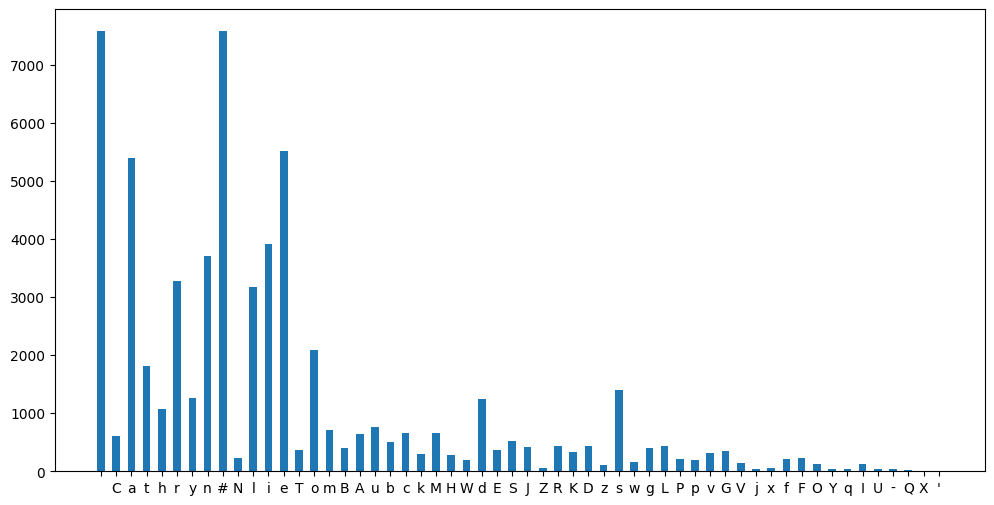

In [3]:
# TODO: plot frequencies (how often each letter is used)
#<your code>
def plot_frequencies(strings):
    # Combine all strings into a single one
    combined_string = "".join(strings)

    # Count the frequencies of each letter
    letter_counts = collections.Counter(combined_string)

    # Get the letters and their frequencies as separate lists
    letters, frequencies = zip(*letter_counts.items())

    # Plot the frequencies using a bar chart
    fig, ax = plt.subplots(figsize=(12, 6))  # Set the size of the figure
    ax.bar(letters, frequencies, width=0.5)  # Set the width of the bars
    plt.show()

plot_frequencies(names)

# HINT: use plt.bar

max length = 17


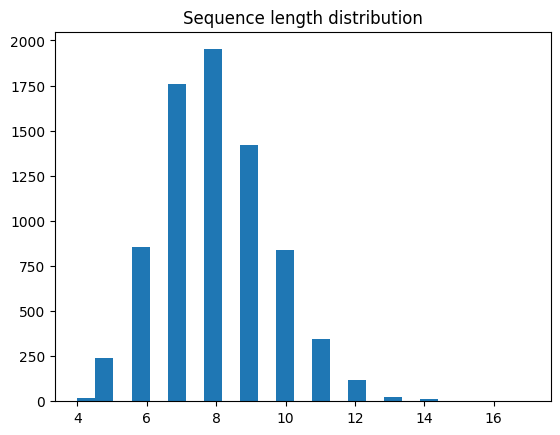

In [4]:
# there are names of different lenghs
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [5]:
names[:10]

[' Zea#',
 ' Glennis#',
 ' Frederick#',
 ' Marius#',
 ' Daryn#',
 ' Davida#',
 ' Arel#',
 ' Kelcie#',
 ' Carey#',
 ' Jim#']

In [4]:
# TODO: select unique tokens and fill in two dictionaries for token conversion <-> indices
# make space 0
    
tokens = list(set(''.join(names[:])))

#putting empty space character the first element in tokens so it takes id = 0
tokens.remove(' ')
tokens.insert(0, ' ')
tok2id = {tok: i for i, tok in enumerate(tokens)}

id2tok = {value: key for key, value in tok2id.items()}

n_tokens = len(tokens)
print ('There are {} tokens',n_tokens)

assert 50 < n_tokens < 60

print('Vocabular: ' + "".join(tokens))

There are {} tokens 56
Vocabular:  I'CjrNoUtcvMekFGPQASqxuaWgnDlzidwXBH-ZLJpOmfR#sYhbKEyTV


In [5]:
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [6]:
print('\n'.join(names[:10]))
print(to_matrix(names[:10]))

 Cathryn#
 Nataline#
 Tomi#
 Berri#
 Aubry#
 Becky#
 Murial#
 Helli#
 Hal#
 Melina#
[[ 0  3 24  9 49  5 53 27 46  0]
 [ 0  6 24  9 24 29 31 27 13 46]
 [ 0 54  7 43 31 46  0  0  0  0]
 [ 0 35 13  5  5 31 46  0  0  0]
 [ 0 19 23 50  5 53 46  0  0  0]
 [ 0 35 13 10 14 53 46  0  0  0]
 [ 0 12 23  5 31 24 29 46  0  0]
 [ 0 36 13 29 29 31 46  0  0  0]
 [ 0 36 24 29 46  0  0  0  0  0]
 [ 0 12 13 29 31 27 24 46  0  0]]


In [7]:
# TODO: split all the names into training (80%) and test (20%)
#<your code>
def split_data(data, train_size=0.8):
    """
    Splits the input data into train and test sets.

    Parameters:
        data (list): The input list to be split.
        train_size (float, optional): The fraction of the data to be used for training.
            Defaults to 0.8.

    Returns:
        tuple: A tuple containing the train and test lists.
    """
    data_size = len(data)
    train_size = int(train_size * data_size)
    indices = list(range(data_size))
    random.shuffle(indices)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    train_set = [data[i] for i in train_indices]
    test_set = [data[i] for i in test_indices]
    return train_set, test_set

train_data, val_data = split_data(names)

len(train_data), len(val_data)

(6062, 1516)

In [8]:
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from IPython.display import clear_output

# Char-RNN for names

You need to write a net encoding the input character numbers using the Embeddings table.
Pass the resulting tensors through the RNN cell, then convert them into logits to predict the number of the new symbol.

In [9]:
# NB: pay attention to the order of the axes when calling forward
# http://pytorch.org/docs/master/nn.html#recurrent-layers

# Make it possible to choose cell type, RNN, GRU or LSTM
# TODO: fill in the blanks. The forward function will be called by us at each step.
class NameRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, cell = 'rnn', n_layers=1):
        super(NameRNN, self).__init__()
        # Add code to switch cell types RNN/LSTM
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.cell = cell
        
        #<your code>
        self.encoder = nn.Embedding(vocab_size, hidden_size)
        
        if cell == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, batch_first=True)
        elif cell == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        elif cell == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)

        
        self.decoder = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        #-
        
    def forward(self, input, hidden):
        #<your code>
        batch_size = input.size(0)
        
        encoded = self.encoder(input)
        
        output, hidden = self.rnn(encoded, hidden)
        
        
        decoded = self.decoder(output)
        
        output = self.softmax(decoded)
        #-
        return output, hidden

    def init_hidden(self, batch_size):
        if self.cell == "lstm":
            return (torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True),
                    torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True))
        
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True)

# Training

In [10]:
def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()
    
    for batch in train_batches:
        # need to add loss calculation
        
        nums = to_matrix(batch)
        #<your code>
        
        input = torch.tensor(nums[:, :-1], dtype=torch.long)
        target = torch.tensor(nums[:, 1:], dtype=torch.long)

        optimizer.zero_grad()

        hidden = model.init_hidden(input.size(0))

        output, hidden = model(input, hidden)

        loss = F.nll_loss(output.view(-1, model.output_size), target.view(-1))

        loss.backward()

        optimizer.step()
        
        #-
            
        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

def test(model, test_batches):
    loss_log = []
    model.eval()
    for batch in test_batches:  
        
        nums = to_matrix(batch)
        #<your code>
        input = torch.tensor(nums[:, :-1], dtype=torch.long)
        target = torch.tensor(nums[:, 1:], dtype=torch.long)
    
        hidden = model.init_hidden(input.size(0))
        
        #size1.append(input.shape)
        #size1.append(hidden.shape)
        output, hidden = model(input, hidden)
        #size2.append(output.shape)
        #size2.append(hidden.shape)
        loss = F.nll_loss(output.view(-1, model.output_size), target.view(-1))


        #-
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)
        
        val_loss = test(model, test_batches)
        train_log.extend(train_loss)
        
        val_log.append((len(train_log), np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log, val_log)

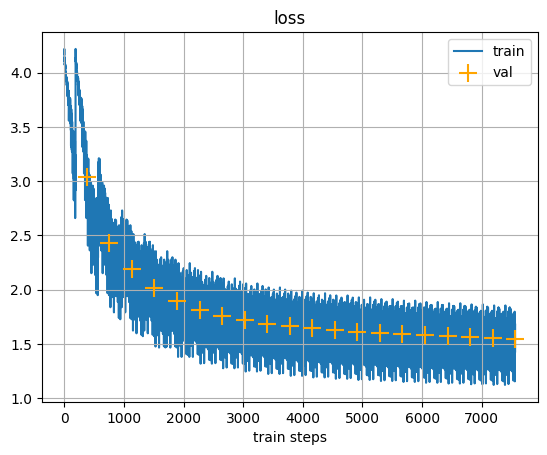

In [26]:
rnn = NameRNN(len(tokens), 50, len(tokens), cell='rnn')

opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)
train(rnn, opt, 20)

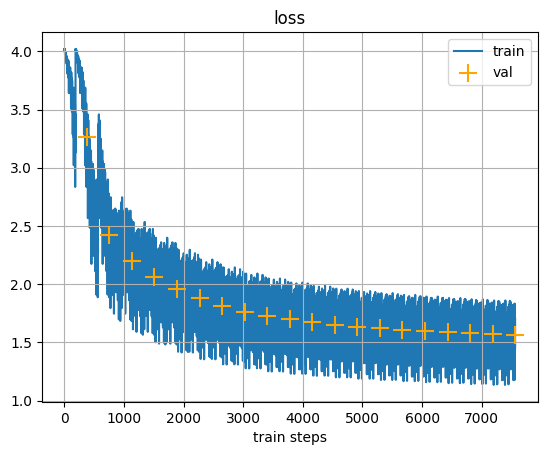

In [23]:
rnn = NameRNN(len(tokens), 50, len(tokens), cell='lstm')

opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)
train(rnn, opt, 20)

# Genration using argmax

In [28]:
# Write a function to generate line continuation
def pick_by_argmax(logits):
    #<your code>
    idx = logits.argmax()
    # return as scalar
    return idx.item()

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)


def gen_continuation(model, prefix=" "):
    hidden = model.init_hidden(1)
    nums = to_matrix(prefix)
    nums = torch.from_numpy(nums)
    
     # TODO: first fold the string with RNN:
     # we are interested in the last output and hidden
     #<your code>
    #nums = nums[-1].unsqueeze(0)
    with torch.no_grad():
        output, hidden = model(nums[-1].unsqueeze(0), hidden)
        last_output = output[:, -1, :]
    
     # TODO: then generate some subsequent characters
     # outs is an array with token numbers
    #<your code>
    outs = []
    for i in range(20):
        token = pick_by_argmax(last_output[0])
        outs.append(token)
        token = torch.tensor([[token]], dtype=torch.long)
        output, hidden = model(token, hidden)
        last_output = output[:, -1, :]
    
    #print(outs)
    print(prefix + '|'+ ids2string(outs))
    
gen_continuation(rnn, " Ku")

 Ku|delle#              


# Generation with sampling 

Regular softmax
$$ p_i = \frac {\exp (x_i)} {\sum \exp(x_j)} $$
can be upgraded with temperature:
$$ p_i = \frac {\exp (x_i / T)} {\sum \exp (x_j / T)} $$

This will allow a smooth transition from choosing the most probable element ($ T << 1 $) to almost equiprobable ($ T >> 1 $)

In [61]:
# Write a batch generation function with sampling from distribution and temperature

    
def batch2string(ids, prefix):
    strings = []
    for batch in ids:
        # convert batch tensor to list
        batch_list = batch.tolist()
        # use ids2string to convert list to string
        string = ids2string(batch_list)
        # add prefix and append to strings list
        strings.append(prefix + string)
    return strings

def pick_by_distribution(logits, temperature = 1):
    # convert logits to probabilities
    # then sample using batch examples
    #<your code>
    probs = F.softmax(logits / temperature, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

import itertools

def gen_continuation_temp(model, prefix=" ", temperature=1.0, n=10):
    hidden = model.init_hidden(n)
    nums = to_matrix([prefix] * n)
    nums = torch.from_numpy(nums)
    
    #print(nums.shape)
    #print(hidden.shape)
    # similarly, first get the batch output, hidden
    #<your code>
    with torch.no_grad():
        output, hidden = model(nums, hidden)
        last_output = output[:, -1, :]
    
    # then, generate n subsequent characters
     # in outs put the matrix of token numbers and display it
    outs = []
    for i in range(5):
        token = pick_by_distribution(last_output, temperature=temperature)
        outs.append(token)
        token = token.unsqueeze(-1)
        output, hidden = model(token, hidden)
        last_output = output[:, -1, :]
        
    print(batch2string(outs, prefix + '|'))

In [64]:
gen_continuation_temp(rnn, prefix=" An", temperature=0.5, n=10)

[' An|disnnnnead', ' An|inaaiaenne', ' An|ealrnn#nee', ' An|##dea# ###', ' An|  e##     ']
